# Custom Datasets

In intro notebook, we used a dataset from torch. In this let's deal with a custom dataset.

We're gonna work on a food classification problem.

In [1]:
# Import
import torch
from torch import nn

print(f"Torch version: {torch.__version__}")

Torch version: 2.0.1+cu118


In [2]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

Info on dataset...

[Food 101 dataset](https://www.kaggle.com/datasets/dansbecker/food-101) 

Food101 is a computer vison benchmark as it contains 1000 images if 101 different kind of foods, totalling 101,000 images (75,750 train and 25,250 test)

We're gonna start small with 3 classes: pizza steak sushi and use random 10% of data.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


* We've downloaded the data in Image classification format,
* Image classificataion format --> Images of each classes in their own directory.
* [custom_data_creation.ipynb](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) --> The entire walthrough of creation of this format can be found in this notebook.

In [4]:
# Let's check out the image classification format directory structure
import os
os.listdir("data/pizza_steak_sushi/train/")

['pizza', 'steak', 'sushi']

For any custom dataset, the premise remains the same: `Find a way to best turn it into a dataset compatible with PyTorch`

In [5]:
# Small function to walk through data directory
def walk_through_dir(dir_path):
  """
  Walks through dir_path and returns it's contents
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)}  and {len(filenames)} in {dirpath} directory")

In [6]:
walk_through_dir("data/")

There are 1  and 1 in data/ directory
There are 2  and 0 in data/pizza_steak_sushi directory
There are 3  and 0 in data/pizza_steak_sushi/train directory
There are 0  and 78 in data/pizza_steak_sushi/train/pizza directory
There are 0  and 75 in data/pizza_steak_sushi/train/steak directory
There are 0  and 72 in data/pizza_steak_sushi/train/sushi directory
There are 3  and 0 in data/pizza_steak_sushi/test directory
There are 0  and 25 in data/pizza_steak_sushi/test/pizza directory
There are 0  and 19 in data/pizza_steak_sushi/test/steak directory
There are 0  and 31 in data/pizza_steak_sushi/test/sushi directory


In [7]:
# Setup train and test paths
from pathlib import Path
image_path = Path("data/pizza_steak_sushi")
train_dir = f"{image_path}/train"
test_dir = f"{image_path}/test"

In [8]:
# Visualizing images
import random
from PIL import Image

# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

Random image path: data/pizza_steak_sushi/train/pizza/667309.jpg
Image class: pizza
Image height: 384
Image width: 512


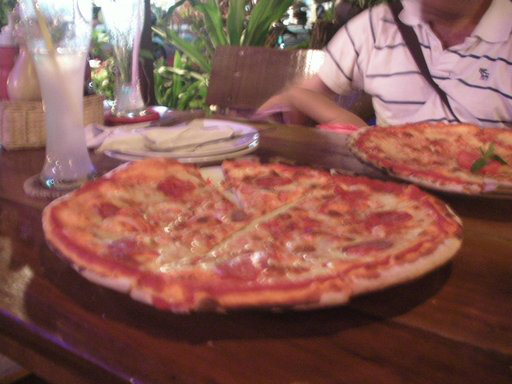

In [9]:
# 2. Get random image path
random_image_path = random.choice(image_path_list)
# 3. Get image class from path name
image_class = random_image_path.parent.stem
# 4. Open image
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

The images has different heights and widths.

## Transforming data
 
To load data into PyTorch

image --> Tensors --> datasets --> dataloader

Different datasets are available for different datatypes, listing a few,

* torchvision.datasets --> images
* torchaudio.datasets --> audio

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

`torchvision.transforms` --> Provides us plenty of tools to convert images to Tensors, augument and combine all these steps into one.

In [11]:
# Transform a image
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), # Resize images to 64 * 64
    transforms.RandomHorizontalFlip(p=0.5), # Flip images horizontally, p probabality of image flip
    transforms.ToTensor() # Converts pixel values from 0 to 255 to 0.0 and 0.1, Normalize
])

In [12]:
# Function to try the transform on various images
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Plots a series of images from random_paths

  Will open n random images from image paths, transform them and shows them side by side

  Args:
    image_paths (list): List of image paths.
    transform (torchvision.transforms): Trnasforms to apply to images.
    m (int, optional): Number of images to plot. Defaults to 3.
    seed (int, optional): Random seed for the random generator. Defaults to 42.
  """

  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib
      # Pytorch default [C, H, W], matplotlib [H, W, C]
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transfomed \nSize: {transformed_image.shape}")
      ax[1].axis("off")
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


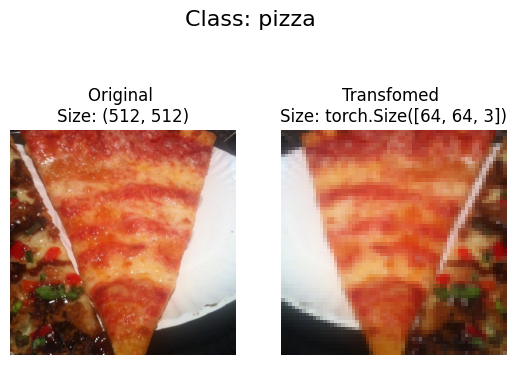

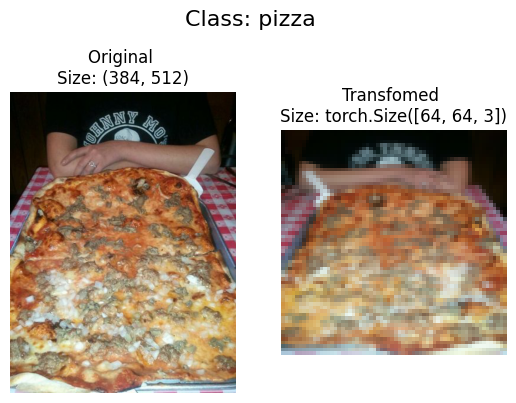

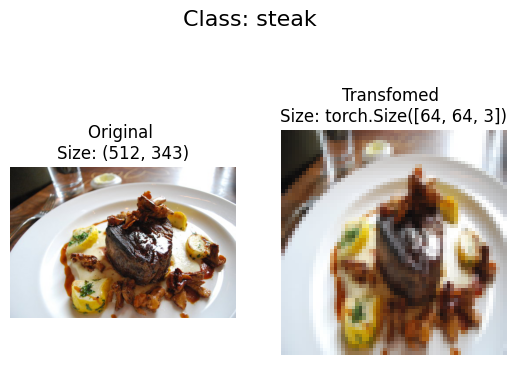

In [13]:
plot_transformed_images(image_path_list, transform=data_transform)

Larger image --> More pixels --> More information --> More computation

## Load Image Data with ImageFolder

[torchvision.datasets.ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(
    root=train_dir, # target folder of images
    transform=data_transform, # transforms to apply
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform
)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


PyTorch has registered our dataset. Let's inspect it.

In [15]:
# List of class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [18]:
# Let's take a sample from dataset and explore them
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: 
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) --> [channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) --> [height, width, channels]


Text(0.5, 1.0, 'pizza')

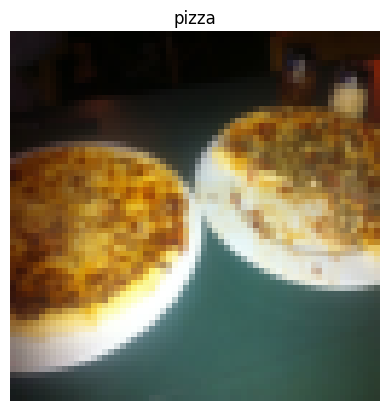

In [19]:
# Plotting an single image
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} --> [channels, height, width]")
print(f"Image permute shape: {img_permute.shape} --> [height, width, channels]")

# Plot the image
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label])

Images are more pixelated because of 512x512 --> 64x64

### Load dataset into DataLoder

In [20]:
# Turn train and test datasets into dataloders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    dataset=train_data, # dataset to load
    batch_size=1, # sample per batch,
    num_workers=1, # number of subprocesses to load
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=1,
)

In [21]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fdac9feb880>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdac9febdc0>)

In [22]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} --> (batch, channel, height, width)")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) --> (batch, channel, height, width)
Label shape: torch.Size([1])


## Loading image with Custom Dataset

What if a pre-built `Dataset` creator like `torchvision.datasets.ImageFolder()` didn't exist?

Let's recreate ImageFolder usint `torch.utils.data.Dataset`

In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get class names

1. Get class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if the class names aren't found(if this happens, there might be something wrong with directory structure)
3. Turn class names into a dicitionary of numeric labels, one for each class

In [25]:
# Setup path for target dictionary
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(train_dir))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [26]:
list(os.scandir(train_dir))[0].name

'pizza'

In [27]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Find the class folder names in a target directory

  Assumes target directory in image classifiation format

  Args:
    directory (str): target directory to load classnames from

  Returns:
    Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_names:idx))
  """

  # 1. Get class names by scannin the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  # 3. Create a dictionay of index labels  (computers prefer numerical rather than string labels)
  class_to_idx = {cls_name:i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [28]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [29]:
# Let's write the dataset
from torch.utils.data import Dataset

# Subclass dataset
class ImageFolderCustom(Dataset):
  # Initialize target_dir and transform
  def __init__(self, target_dir: str, transform=None) -> None:

    # Create class attributes
    # Get all paths
    self.paths = list(Path(target_dir).glob("*/*.jpg")) # Change format according to image
    # setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(target_dir)

  # Function to load images
  def load_image(self, index: int) -> Image.Image:
    """
    Opens an image via a path and returns it
    """

    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite __len__()
  def __len__(self) -> int:
    """
    Returns total number of samples
    """
    return len(self.paths)

  # Overwrite __get_item__() method
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """
    Returns one sample of data and label(X, y)
    """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [30]:
# Augment train data
train_transforms = transforms.Compose(
[    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), # 0.5 default
    transforms.ToTensor()]
)

# Don't augment test data only reshape
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [31]:
# Let's try the custom dataset
train_data_custom = ImageFolderCustom(
    target_dir=train_dir,
    transform=train_transforms,
    )
test_data_custom = ImageFolderCustom(
    target_dir=test_dir,
    transform=test_transforms,
)

In [32]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fdac9fe82e0>,
 <__main__.ImageFolderCustom at 0x7fdac9feada0>)

In [33]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [34]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Let's write a function to visualize images from the dataset
def display_random_images(
    dataset: torch.utils.data.dataset.Dataset,
    classes: List[str] = None,
    n: int = 10,
    display_shape: bool = True,
    seed: int = None
):
  # Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10. Setting to 10 and removing shape display")

  # Random seed
  if seed:
    random.seed(seed)

  # Get random samples
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Addjust image tensor for plotting
    targ_img_permutated = targ_image.permute(1, 2, 0)

    # Plot adjusted images
    plt.subplot(1, n, i+1)
    plt.imshow(targ_img_permutated)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_img_permutated.shape}"
    plt.title(title)

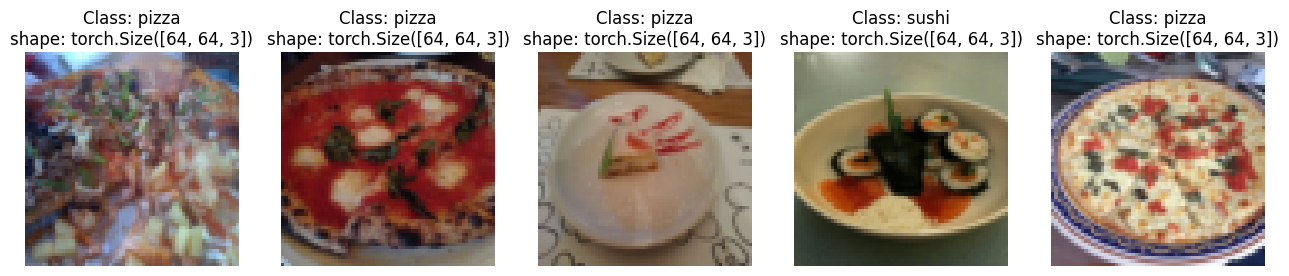

In [37]:
display_random_images(train_data, n=5, classes=class_names, seed=None)

### Turn custom loaded images into DataLoader

In [38]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=1,
    num_workers=0,
    shuffle=True,
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=1,
    num_workers=0,
)

In [39]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7fdac9df3dc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdaca007d00>)

In [40]:
# Let's look at the shapes
img, label = next(iter(train_dataloader_custom))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


## Other transformations

We did some transformations also called **Data augumentation** with [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html)

The idea behing data augumentation is to diversify our training data artifically to make the model generalize better.

Ther are two top augumentations in transforms library which are random(really good).

* `transforms.RandAugment()`
* `transforms.TrivialAugmentWide()`

For these we set a random magniture for the level of augmentation and these might perform better than hand picked augumentations.

PyTorch Team used TrivialAugment to train their latest sota models.

In [41]:
# Let's create TrivialAugment transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # num_magnitude_bins -> Intensity of augumentaion 31 max0 min
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
])

In [42]:
# Let's test the augumentation
image_path_list = list(image_path.glob("*/*/*.jpg"))

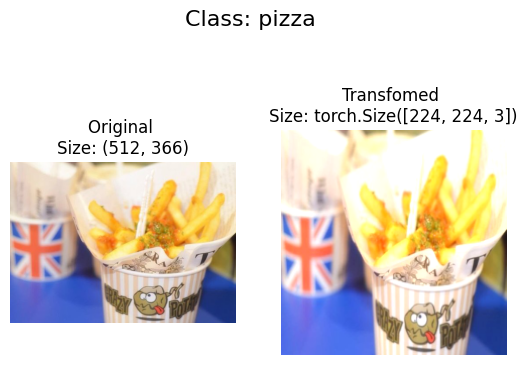

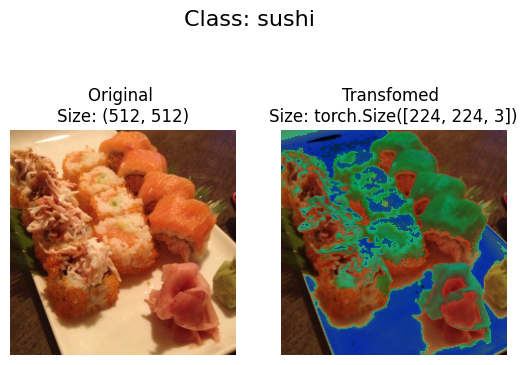

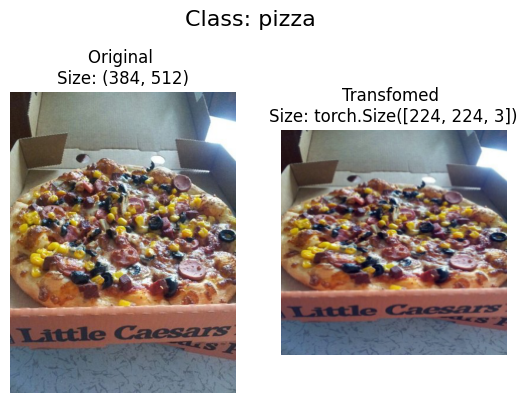

In [43]:
# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## Model 0: TinyVGG without data augumentation

### Creating transforms and loading data for model

In [44]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [130]:
# Load and transofrm data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform,
)
test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform,
)

# Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2 # Number of cpu's

print(f"Creating dataloader with batch size {BATCH_SIZE} and {NUM_WORKERS} workers")

train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)
train_dataloader_simple, test_dataloader_simple

Creating dataloader with batch size 32 and 2 workers


(<torch.utils.data.dataloader.DataLoader at 0x7f84b4e9e6e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f84b5079810>)

### Create TinyVGG model

Model architecture from cnn-explainer

In [101]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from cnn-explainer
  """

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int, verbose=False) -> None:
    super().__init__()
    self.verbose = verbose
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1,
            ),
  
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        ),
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            padding=1,
        ),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features=hidden_units*16*16, # Got 16 from forward pass on a single iamge
            out_features=output_shape
        )
    )

  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    if self.verbose:
        print(x.shape)
    x = self.conv_block_2(x)
    if self.verbose:
      print(x.shape)    
    x = self.classifier(x)
    if self.verbose:
      print(x.shape)
    return x

    # Instantiate model
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape=3, # number of colour channels
    hidden_units=10,
    output_shape=len(train_data.classes),
    verbose=True
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [97]:
image_batch, label_batch = next(iter(train_dataloader_custom))
img_single, label_single = image_batch[0].unsqueeze(dim=0), label_batch[0]
img_single.shape

torch.Size([1, 3, 64, 64])

In [102]:
model_0.eval()
model_0(img_single)

torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 3])


tensor([[0.0673, 0.0663, 0.0386]], grad_fn=<AddmmBackward0>)

In [104]:
model_0.verbose = False
with torch.inference_mode():
    pred = model_0(img_single)

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabalities:\n{torch.softmax(pred, dim=-1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=-1), dim=-1)}\n")
print(f"Actual label:\n{label_single}\n")

Output logits:
tensor([[0.0673, 0.0663, 0.0386]])

Output prediction probabalities:
tensor([[0.3366, 0.3363, 0.3271]])

Output prediction label:
tensor([0])

Actual label:
0



In [107]:
# Visualizing the model
from torchinfo import summary
summary(model_0, input_size=img_single.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### Functionizing training and test steps

* `train_step()` to train the model
* `test_step()` to test the model
* `train()` training loop combining above two functions

In [109]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device = None
):
    """_summary_

    Args:
        model (nn.Module): model to train
        dataloader (torch.utils.data.DataLoader): train dataloader to train model on
        loss_fn (nn.Module): loss to evaluate predictions
        optimizer (torch.optim.Optimizer): Optimizer to train model
        device (torch.device, optional): Device to train model on. Defaults to None.

    Returns:
        float, float: loss, accuracy
    """

    # Set model to train mode
    model.train()

    # Set metrics and loss trackers
    train_loss, train_acc = 0, 0

    for x, y in dataloader:

        x = x.to(device)
        y = y.to(device)

        # Forward pass
        y_pred = model(x)

        # compute loss
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=-1), dim=-1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [135]:
# Test step
# Params model, dataloader, loss, device
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    device: torch.device = None
):
    """_summary_

    Args:
        model (nn.Module): model to evaluate
        dataloader (torch.utils.data.DataLoader): test dataloader to evaluate model on
        loss_fn (nn.Module): loss to evaluate model
        device (torch.device, optional): Device to test model on. Defaults to None.

    Returns:
        float, float: loss, accuracy
    """

    # Setup model to eval mode
    model.eval()

    # Setup stats to track loss accuracy
    test_loss, test_accuracy = 0, 0

    for x, y in dataloader:

        # Set to device
        x = x.to(device)
        y = y.to(device)

        # Forward pass to get preds
        test_pred = model(x)

        # Calculate loss
        loss = loss_fn(test_pred, y)
        test_loss += loss

        # Calculate accuracy
        test_pred_labels = torch.softmax(test_pred, dim=-1).argmax(dim=-1)
        test_accuracy += (test_pred_labels == y).sum().item() / len(y)

    # Adjust loss and accuracy for batch
    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    return test_loss, test_accuracy

In [139]:
# Function to use train_step and test_step
# Number of epochs to train the model
# ALl the parameter train_step and test_step uses

import torch

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device = None
):
    """_summary_

    Args:
        model (nn.Module): Model to train
        train_dataloader (torch.utils.data.DataLoader): Data to train model
        test_dataloader (torch.utils.data.DataLoader): Data to evaluate model
        loss_fn (nn.Module): Loss to train model
        optimizer (torch.optim.Optimizer): Optimizer to tune weights
        epochs (int): Number of epochs to train model
        device (torch.device, optional): Device to train model. Defaults to None.
    """

    # Setup stats to track
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):

        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
        )

        print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f} | Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.3f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results['test_loss'].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [140]:
# Initialize loss and optimzer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [141]:
# Train model
results = train(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device
)

Epoch: 0 | Train loss: 1.097 | Train accuracy: 0.414 | Test loss: 1.121 | Test accuracy: 0.198
Epoch: 1 | Train loss: 1.093 | Train accuracy: 0.414 | Test loss: 1.135 | Test accuracy: 0.198
Epoch: 2 | Train loss: 1.091 | Train accuracy: 0.414 | Test loss: 1.145 | Test accuracy: 0.198
Epoch: 3 | Train loss: 1.109 | Train accuracy: 0.293 | Test loss: 1.141 | Test accuracy: 0.198
Epoch: 4 | Train loss: 1.092 | Train accuracy: 0.414 | Test loss: 1.150 | Test accuracy: 0.198
Epoch: 5 | Train loss: 1.102 | Train accuracy: 0.293 | Test loss: 1.148 | Test accuracy: 0.260
Epoch: 6 | Train loss: 1.093 | Train accuracy: 0.426 | Test loss: 1.148 | Test accuracy: 0.260
Epoch: 7 | Train loss: 1.100 | Train accuracy: 0.305 | Test loss: 1.153 | Test accuracy: 0.198
Epoch: 8 | Train loss: 1.094 | Train accuracy: 0.418 | Test loss: 1.152 | Test accuracy: 0.260
Epoch: 9 | Train loss: 1.089 | Train accuracy: 0.426 | Test loss: 1.154 | Test accuracy: 0.260
